## Classification with word2vec 

-- Prof. Dorien Herremans

In this second part of the lab, we will be tackling a classification problem by first loading word embeddings and feeding those in a simple classifier. We compare this to naive alternative approaches. 

During this tutorial, you will need some of the following libraries, let's install them first if you don't have them: 

In [ ]:
#STUDENT NUMBER: 

# 1004365

In [ ]:
# Use this to install libraries if you find them missing on your system: 
# !pip install bs4 
# !pip install sklearn
# !pip install nltk
# !pip install gensim
# !pip install lxml

Now we can import some libraries that we will use:

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
import lxml
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

%matplotlib inline

### TFIDF with logistic regression

#### Preparing the dataset

The classification problem at hand is to predict the tag that belongs to a Stack Overflow post. By the way, if you are not familiar with Stack Overflow, do check it out, it is a tremendous help when facing any coding issues. The data from Google BigQuery is available at the github below. If the link does not work you may have to download it manually from github then upload to Colab:

https://github.com/dorienh/class_materials/blob/main/datasets/stack-overflow-data.csv
 
 We can read it directly into a pandas dataframe. 


In [2]:
url = "https://github.com/dorienh/class_materials/blob/main/datasets/stack-overflow-data.csv?raw=true"

df = pd.read_csv(url, encoding = 'latin-1')

Let's start by having a look at our data: 

In [3]:
# only keep data that has a tag (is labeled): 
df = df[pd.notnull(df['tags'])]

# display first ten rows:
df.head(10)

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


Our task: predict the tag based on the post content. 

The size of our word embedding will be chosen based on how many unique words are in the dataset (meaning in the article text or posts): 

In [4]:
# Count the number of words: 
df['post'].apply(lambda x: len(x.split(' '))).sum()

10286120

We have over 10 million words in the data. That's a lot! 


Let's visualise our dataset: 



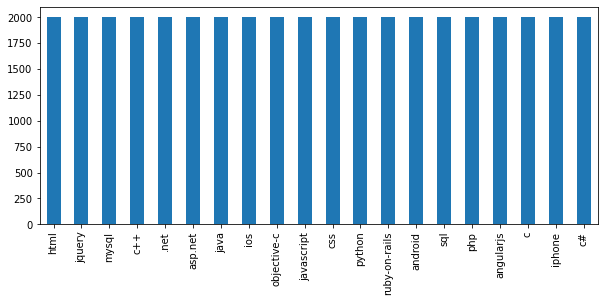

In [5]:
# visualising dataset
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

As you can see, the classes are very well balanced.

Now let's have a look at the data of the posts ('post' columns) in more detail: 

In [6]:
print(df['post'].values[10])

when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interface where and when to use it


As you can see, the text needs to be cleaned up a bit. Below we use the `nltk` toolkit to remove spaces, html tags, stopwords, symbols etc. We define a function to remove stop words, replace / \ and other symbols.

In [7]:
# note: slower students may wish to skip this step to finish the lab in class
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

# load a list of stop words
nltk.download('stopwords')


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string 
        return: modified initial string
    """
    text = BeautifulSoup(text, 'html.parser').text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Now we can apply the newly defined function on the column of `df 'post'`. 

In [8]:
df['post'] = df['post'].apply(clean_text)

Let's check the results: 

In [9]:
print(df['post'].values[10])

need interface c# possible duplicate would want use interfaces need interface want know use example interface idemo function prototype public void show first class using interface class myclass1 idemo public void show function body comes responsewrite myclass second class using interface class myclass2 idemo public void show function body comes responsewrite myclass2 responsewrite two classes function name different body even achieved without interface need interface use


This looks a lot better!

Now how many unique words do we have in this cleaned up dataset? 

In [10]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

3424194

Now we have over 3 million words to work with, that's 7 million removed tags.

Before we start creating classifiers, let's split our dataset 70-30 in a test set (for evaluation) and training set: 

In [11]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

#### Logistic regression

Now that we have our features, we can train a classifier to try to predict the tag of a post. We will start with logistic regression and TFIDF representation which provides a nice baseline for this task. 

To make the vectorizer => transformer => classifier easier to work with, we will use the `Pipeline` class in Scikit-Learn that behaves like a compound classifier.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

# we define a Pipeline, which first represents our features as TFID
# Then performs logistic regression
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

How well does it work? 

In [13]:
# to show the computation time: 
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7861666666666667
               precision    recall  f1-score   support

         .net       0.67      0.64      0.65       613
      android       0.91      0.90      0.91       620
    angularjs       0.97      0.93      0.95       587
      asp.net       0.76      0.75      0.75       586
            c       0.78      0.83      0.81       599
           c#       0.61      0.59      0.60       589
          c++       0.79      0.76      0.77       594
          css       0.84      0.87      0.85       610
         html       0.70      0.73      0.71       617
          ios       0.61      0.59      0.60       587
       iphone       0.65      0.63      0.64       611
         java       0.83      0.82      0.83       594
   javascript       0.77      0.79      0.78       619
       jquery       0.85      0.85      0.85       574
        mysql       0.82      0.85      0.83       584
  objective-c       0.66      0.66      0.66       578
          php       0.82      0.83  

That's quite a good accuracy. Now let's see if we can combine **word2vec** with logistic regression by feeding the new embedded representation to our logistic regression instead of the bag of words representation of TFIDF. 

### Word2vec embedding and Logistic Regression

Let's load a pretrained word2vec model, and use the embedding representation as input to a simple classifier (i.e. logistic regression). 

You can use the word2vec model you trained in the first part of the lab (on the Shakespeare text), or load this (quite big, 1.5GB) pretrained word2vec model from Google trained on Google News data. 

If you load an model you trained yourself, use#
`wv = gensim.models.KeyedVectors.load_word2vec_format("yourweights.bin.gz", binary=True)`. We will be loading pretrained weights available in gensim itself:

(This may take a while!)




In [14]:
%%time
import gensim.downloader
from gensim.models import Word2Vec

wv = gensim.downloader.load('word2vec-google-news-300')
wv.init_sims(replace=True)
print('Model loaded')


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Model loaded
CPU times: user 13min, sys: 1min 57s, total: 14min 58s
Wall time: 17min 52s


If you are interested how good these pretrained embeddings are, you could try some of the similarity tests we did in part 1 of the lab on the Shakespeare text. Only now we have a larger vocabulary, e.g.:  

In [15]:
wv.most_similar('twitter')

[('Twitter', 0.89089035987854),
 ('Twitter.com', 0.7536780834197998),
 ('tweet', 0.7431625723838806),
 ('tweeting', 0.7161933183670044),
 ('tweeted', 0.7137226462364197),
 ('facebook', 0.6988551616668701),
 ('tweets', 0.6974530816078186),
 ('Tweeted', 0.6950210928916931),
 ('Tweet', 0.6875007152557373),
 ('Tweeting', 0.6845167279243469)]

Gensim offers a number of pretrained models for you to choose from (convenient right!). You can check a list of available model like this: 

In [16]:
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


As we have multiple words for each post, we will need to somehow combine them. A common way to achieve this is by averaging the
word vectors per document. In later classes you can feed the individual words to memory models like LSTM. For a quick solution here, we can use a summation or weighted addition. The function below takes as input a list of words and the word2vec model `wv`. Then it retrieves the vector embeddings for each of the words and averages them. 

In [17]:
def word_averaging(wv, words):
    # averages a set of words 'words' given their wordvectors 'wv'
    
    all_words, mean = set(), []
    
    # for each word in the list of words
    for word in words:
        # if the words are alread vectors, then just append them
        if isinstance(word, np.ndarray):
            mean.append(word)
        # if not: first get the vector embedding for the words
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    
    if not mean:
        # error handling in case mean cannot be calculated
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.vector_size,)

    # use gensim's method to calculate the mean of all the words appended to mean list
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

Below, we explore a way (slightly different from the method used in part 1 of the lab) to create tokens out of sentences, by using the `nltk` toolkit. 

In [18]:
import nltk.data
nltk.download('punkt')

def w2v_tokenize_text(text):
    # create tokens, a list of words, for each post. This function will do some cleaning based on English language
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Let's also split the dataset in training and test set like before, and tokenize each of these datasets using the method defined above.

In [19]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

Since we have multiple word vectors per article, we can take multiple approaches (a powerful LSTM approach as we'll see later, or doc2vec as per below, but first we try a naive approach of averaging). We can average the word positions for each post in this new dataset using the functions we defined above and based on our word2vec model `wv`.

In [20]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  del sys.path[0]


Now we have a way to represent our input! This can then be fed to any classifier, like logistic regression: 

In [21]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['tags'])
y_pred = logreg.predict(X_test_word_average)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Let's evaluate how accurate this averaged word2vec representation with logistic regression is:

In [22]:
print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred))

accuracy 0.6323333333333333
               precision    recall  f1-score   support

         .net       0.63      0.56      0.59       613
      android       0.76      0.76      0.76       620
    angularjs       0.64      0.66      0.65       587
      asp.net       0.54      0.50      0.52       586
            c       0.70      0.73      0.71       599
           c#       0.39      0.43      0.41       589
          c++       0.63      0.63      0.63       594
          css       0.73      0.78      0.75       610
         html       0.57      0.62      0.60       617
          ios       0.55      0.53      0.54       587
       iphone       0.57      0.52      0.54       611
         java       0.63      0.59      0.61       594
   javascript       0.64      0.61      0.62       619
       jquery       0.59      0.57      0.58       574
        mysql       0.68      0.73      0.71       584
  objective-c       0.41      0.40      0.41       578
          php       0.67      0.70  

Now you can see that the accuracy went down! Oh no! Why is that? Because we used a very naive approach: averaging our vectors. A better way to approach this would be doc2vec, which learns relationships between documents (posts in this case), instead of words. The accuracy could also improve by using a different classifier instead of logistic regression, or by changing the aggregation strategy and feed it to an LSTM/RNN model. 

## Doc2vec and Logistic Regression (advanced)

The idea of word2vec can be extended to documents whereby instead of learning feature representations for words, we learn it for sentences or documents. Doc2Vec extends the idea of word2vec, however words can only capture so much, there are times when we need relationships between documents and not just words.

The way to train doc2vec model for our Stack Overflow questions and tags data is very similar to when we trained multi-class text classification with word2vec and logistic regression above.

First, we label the sentences. Gensim’s Doc2Vec implementation requires each document/paragraph to have a label associated with it that indicates if it's part of the test or training set. We do this by using the TaggedDocument method. The format will be `TRAIN_i` or `TEST_i` where `i` is a dummy index of the post.

First let's import the necessary libraries. 


In [23]:
from tqdm import tqdm
from gensim.models import doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

Let's start by defining a function that labels our documents in the corpus. We just give them dummy labels TRAIN_i or TEST_i for post i. Given a corpus and labels, we return a variable that includes a label indicating if it's test or training data. 

In [24]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

Just like above we split our dataset up in test and training data.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.post, df.tags, random_state=0, 
                                                    test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

Let's have a look how our data looks at this moment: 

In [26]:
all_data[:10]

[TaggedDocument(words=['fulltext', 'search', 'php', 'pdo', 'returning', 'result', 'searched', 'lot', 'matter', 'find', 'wrong', 'setup', 'trying', 'fulltext', 'search', 'using', 'pdo', 'php', 'get', 'results', 'error', 'messages', 'table', 'contains', 'customer', 'details', 'id', 'int', '11', 'auto_increment', 'name', 'varchar', '150', 'lastname', 'varchar', '150', 'company', 'varchar', '250', 'adress', 'varchar', '150', 'postcode', 'int', '5', 'city', 'varchar', '150', 'email', 'varchar', '250', 'phone', 'varchar', '20', 'orgnr', 'varchar', '15', 'timestamp', 'timestamp', 'current_timestamp', 'run', 'sqlquery', 'alter', 'table', 'system_customer', 'add', 'fulltext', 'name', 'lastname', 'except', 'columns', 'id', 'postcode', 'timestamp', 'signs', 'trouble', 'far', 'idea', 'problem', 'lies', 'db', 'configuration', 'php', 'code', 'goes', 'php', 'sth', 'dbhprepare', 'select', 'name', 'lastname', 'company', 'adress', 'city', 'phone', 'email', 'orgnr', 'db_pre', 'customer', 'match', 'name',

Gensim allows us to build a model very easily. We can vary the parameters to fit your data: 

*    `dm=0` , distributed bag of words (DBOW) is used.
*    `vector_size=300` , 300 vector dimensional feature vectors.
*    `negative=5` , specifies how many “noise words” should be drawn.
*    `min_count=1`, ignores all words with total frequency lower than this.
*    `alpha=0.065` , the initial learning rate.

We initialize the model and train for 30 epochs. (Those of you on slower computers may want to train for less epochs). Be sure to set your runtime to GPU hardware acceleration! Maybe test with a lower amount of epochs first to see how high you can go during class time!


In [27]:
model_dbow = doc2vec.Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, 
                     min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 40000/40000 [00:00<00:00, 2232794.25it/s]


In [28]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), 
                     total_examples=len(all_data), 
                     epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 40000/40000 [00:00<00:00, 2133528.66it/s]


Now let's define a function to get the vector of a particular word from this trained  model, so that we can feed them into the logistic regression:

In [29]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

We can use this function to create a vectorised training and test set with 1 entry per document for the input in classification models such as logistic regression. 

In [30]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

We can now feed these vectors to the classifier again: 

In [31]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


accuracy 0.7975
               precision    recall  f1-score   support

         .net       0.69      0.67      0.68       589
      android       0.88      0.90      0.89       661
    angularjs       0.94      0.93      0.93       606
      asp.net       0.75      0.76      0.76       613
            c       0.85      0.88      0.87       601
           c#       0.69      0.69      0.69       585
          c++       0.87      0.81      0.84       621
          css       0.83      0.84      0.84       587
         html       0.69      0.66      0.67       560
          ios       0.65      0.65      0.65       611
       iphone       0.65      0.65      0.65       593
         java       0.79      0.85      0.82       581
   javascript       0.78      0.76      0.77       608
       jquery       0.84      0.84      0.84       593
        mysql       0.82      0.81      0.81       592
  objective-c       0.69      0.66      0.68       597
          php       0.85      0.85      0.85    

We get 80%, that is the best result so far! Remember, we can actually use any classifier with this method! So up to you to make your project as efficient as possible :)
    
Try using a different classifiers, e.g. Decision tree or SVM. Does that influence the results? 

New methods are coming out every day in the field of data science. Just at the end of August 2019, the first implementation of BERT for document classfication was published: DocBERT: https://arxiv.org/abs/1904.08398

These embeddings can similarly be loaded. There are also specialised pretrainend embeddings for say, financial data, e.g. FinBERT. 

## References

* https://radimrehurek.com/gensim/models/word2vec.html
* https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
* https://github.com/kavgan/nlp-text-mining-working-examples/tree/master/word2vec
* https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5]

## Exercise

Now over to you! 

Can you develop a doc2vec with SVM classifier for the following dataset? 

https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv

You can also find this dataset here: https://dorienherremans.com/drop/CDS/word2vec/fake.zip

The task is to predict if news is fake or real. 

As input, use only the text for simplicity (possibly concatenated with title, but not necessary). 

Good luck! 

In [37]:
## solution

# read the data after download from DH website and upload to colab
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

#label the data
fake_df["true"] = 0
true_df["true"] = 1

#concatenate 2 pd
data = pd.concat([fake_df, true_df])
data.head(10)

,title,text,subject,date,true
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


In [38]:
data['text'] = data['text'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=cJZFepSvxzM" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=-7Tn4gi_Os8" looks like a URL. Beautiful Soup is not an HTTP client. Y

In [41]:
# split the data
X, y = data['text'], data['true']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, 
                                                    test_size=0.4)


X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [42]:
model_dbow = doc2vec.Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, 
                     min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), 
                     total_examples=len(all_data), 
                     epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 44898/44898 [00:00<00:00, 2106488.52it/s]


In [43]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [45]:
# implement SVM

from sklearn.svm import SVC

svc = SVC(C=5, kernel="sigmoid")
svc.fit(train_vectors_dbow, y_train)

svc = svc.fit(train_vectors_dbow, y_train)
y_pred = svc.predict(test_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.9801781737193764
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9398
           1       0.98      0.98      0.98      8562

    accuracy                           0.98     17960
   macro avg       0.98      0.98      0.98     17960
weighted avg       0.98      0.98      0.98     17960

